In [1]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import videos
from keras.preprocessing.image import ImageDataGenerator 

In [2]:
model = load_model('models/unet.h5')

2022-11-21 18:33:18.504616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 18:33:18.506194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
tf.keras.models.save_model(model, 'unet2.h5')

In [9]:
videos.extract_frames('videos/Modern Times.mp4', 'videos/frames/Modern Times/')

100%|██████████| 3940/3940 [00:57<00:00, 68.09it/s] 

Extracted 3940 frames.


In [7]:
import keras
keras.__version__

'2.8.0'

In [3]:
def custom_generator(data_generator):
    n = data_generator.samples
    batch_size = data_generator.batch_size
    end_index = n - n % batch_size
    while True:
        batch = data_generator.next()
        L_batch = batch[..., 0][..., np.newaxis]
        yield L_batch

def preprocessing(image):
    image = np.array(image, dtype=np.uint8)
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) / 255
    return lab_image

datagen = ImageDataGenerator(
    preprocessing_function = preprocessing
    )

frames_data = datagen.flow_from_directory("/home/arno/Workspace/itc/projects/DeepColor/videos/frames", class_mode=None, target_size=(256, 256), batch_size=32, shuffle=False)

Found 3940 images belonging to 1 classes.


In [11]:
colored_frames = []
for i, grayscale_batch in enumerate(tqdm(custom_generator(frames_data), total=len(frames_data))):
    if i == len(frames_data):
        break
    ab_batch = model.predict(grayscale_batch, verbose=0)
    Lab_batch = np.concatenate((grayscale_batch, ab_batch), axis=-1)
    Lab_batch = (Lab_batch * 255).astype(np.uint8)
    for Lab_frame in Lab_batch: 
        rgb = cv2.cvtColor(Lab_frame, cv2.COLOR_LAB2RGB)
        colored_frames.append(rgb)

  1%|          | 1/124 [00:57<1:57:38, 57.38s/it]


KeyboardInterrupt: 

In [6]:
def create_video_from_frame_array(frames, output_dir, frameSize=(854//2, 480//2)):
    write_path = os.path.join(output_dir, "modern_times_colorized.avi")
    out = cv2.VideoWriter(write_path, cv2.VideoWriter_fourcc(*'DIVX'), 25, frameSize)
    for frame in tqdm(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frame = cv2.resize(frame, frameSize, cv2.INTER_CUBIC)
        out.write(frame)
    out.release()

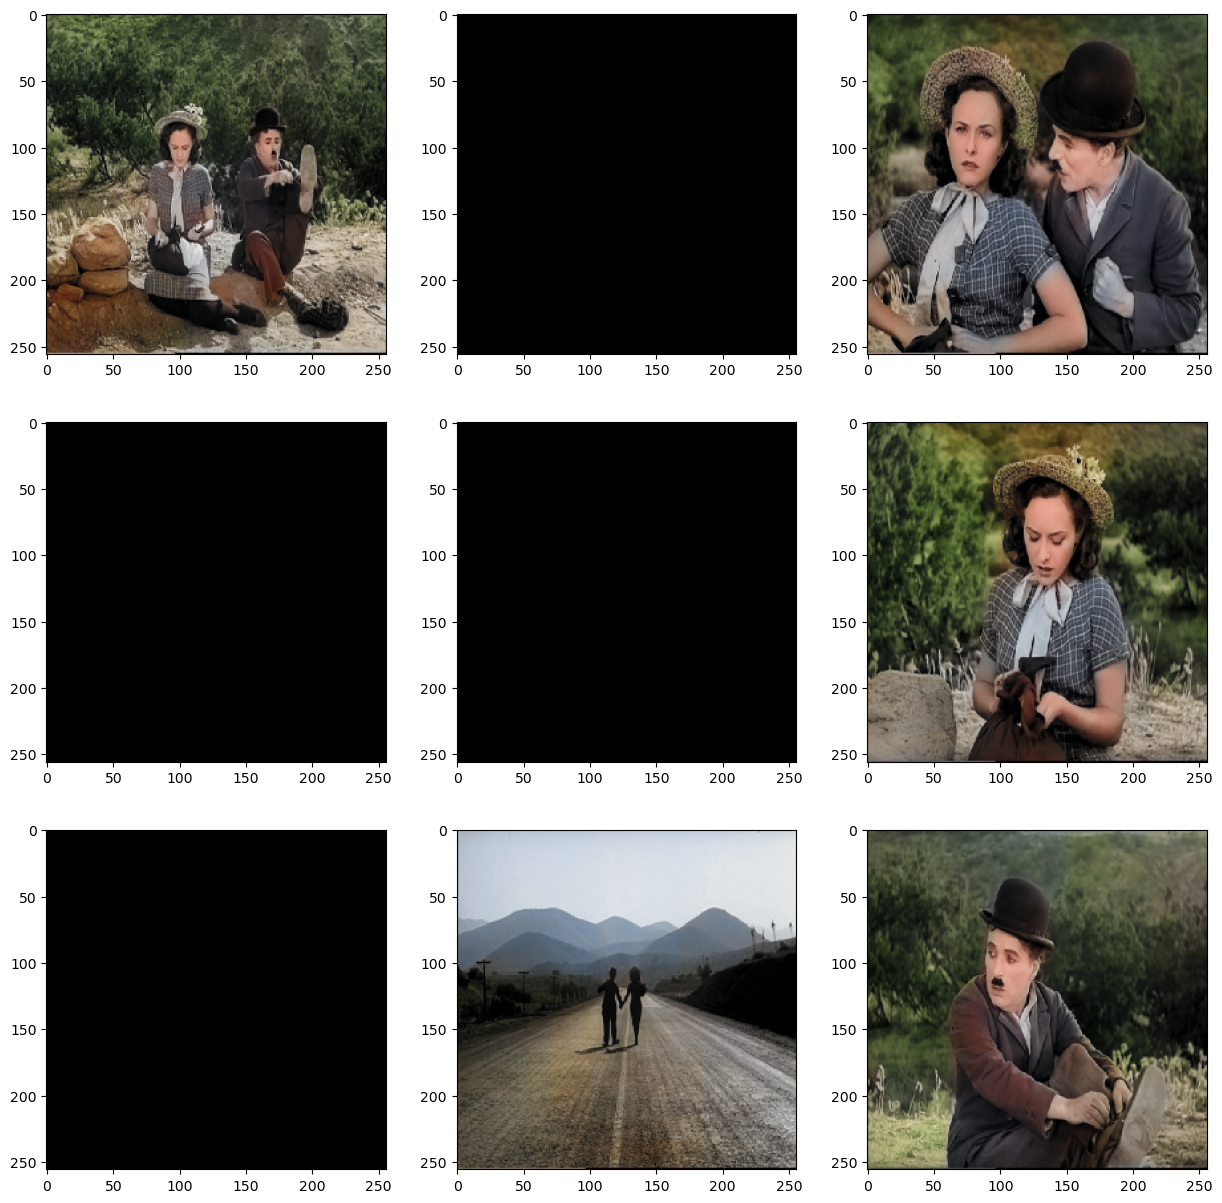

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
    ax = axes.flat[i]
    ax.imshow(random.sample(colored_frames, 1)[0])

In [8]:
create_video_from_frame_array(colored_frames, 'videos/')

100%|██████████| 3153/3153 [00:03<00:00, 933.33it/s] 
